<a href="https://colab.research.google.com/github/ssooni/data_mining_practice/blob/master/dust_weather/dust_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 기상 데이터로 미세먼지 예측 모델링



### 구글 드라이브 마운트 
제 개인 드라이브에 있는 부분이라 아래 부분은 실행해도 학습 데이터 파일은 없습니다.

In [3]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/dataset', force_remount=True)

Mounted at /dataset


In [4]:
!ls -la /dataset/MyDrive/dust/
!pip install --upgrade tables

total 1620512
-rw------- 1 root root         31 Mar 18 03:20 api_key
-rw------- 1 root root         97 Mar 18 03:52 api_key2
-rw------- 1 root root    2439291 Jan  5 03:42 best_model.pt
-rw------- 1 root root 1655826560 Jul  8  2019 data.hdf
-rw------- 1 root root      20499 Mar  3 16:00 LARD_ADM_SECT_SGG_11.dbf
-rw------- 1 root root        761 Mar  3 16:00 LARD_ADM_SECT_SGG_11.prj
-rw------- 1 root root     494976 Mar  3 16:00 LARD_ADM_SECT_SGG_11.shp
-rw------- 1 root root        308 Mar  3 16:00 LARD_ADM_SECT_SGG_11.shx
-rw------- 1 root root     618368 Mar  4 10:43 seoul_municipalities.shp
     |████████████████████████████████| 4.3MB 5.9MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import os

from sklearn.preprocessing import MinMaxScaler

BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

cpu와 cuda 중 다음 기기로 학습함: cuda


## 데이터
데이터는 2009.01.01 ~ 2019.01.01 사이의 서울 날씨와 서울시내 구 별로 설치된 미세먼지 측정 데이터이다.  
미세먼지 측정 데이터와 기상 데이터를 각각 api를 통해서 10년치를 수집 후 hdf 파일로 저장하였으며, 그 과정은 이번 소스 코드에서 제외하였다.  
기상 데이터 항목 중에는 습도, 온도, 풍속, 퐁향, 기압을 사용하였으며, 미세먼지농도는 PM2.5 수치를 사용하였다.


*데이터 출처 : 공공데이터포털*


In [6]:
import pandas as pd
import numpy as np

master = pd.read_hdf("/dataset/MyDrive/dust/data.hdf", "master", mode='r')

master = master.sort_index()

X_label = ['HM', 'PA', 'PS', 'PV','TA', 'TD', 'TS', 'WD', 'WS'] # 습도, 대기압, 
y_label = ['PM25']

master[X_label + y_label].head()

,HM,PA,PS,PV,TA,TD,TS,WD,WS,PM25
2009-01-01,55.0,1013.7,1024.9,1.9,-7.6,-15.0,-10.1,290.0,2.1,14.0
2009-01-01,55.0,1013.7,1024.9,1.9,-7.6,-15.0,-10.1,290.0,2.1,13.0
2009-01-01,55.0,1013.7,1024.9,1.9,-7.6,-15.0,-10.1,290.0,2.1,12.0
2009-01-01,55.0,1013.7,1024.9,1.9,-7.6,-15.0,-10.1,290.0,2.1,18.0
2009-01-01,55.0,1013.7,1024.9,1.9,-7.6,-15.0,-10.1,290.0,2.1,19.0


In [7]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style('whitegrid')

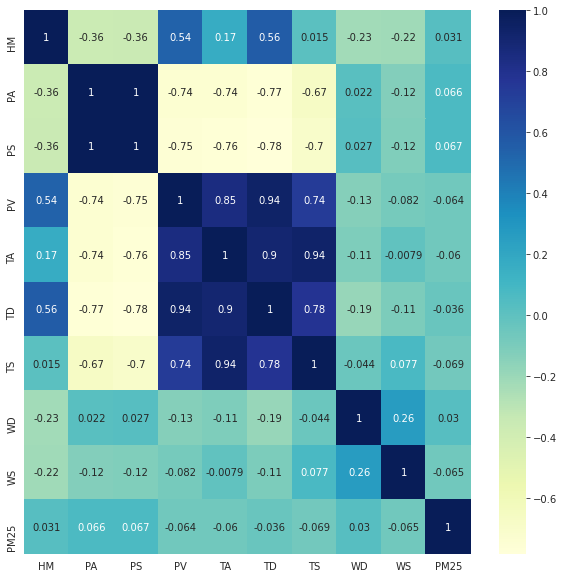

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(master[X_label + y_label].corr(), annot=True, cmap='YlGnBu')

## 데이터 전처리 및 테스트 데이터 분리
1. 누락된 데이터   
미세먼지 데이터의 누락이 있는 데이터가 있다. Nan으로 되어 있는 데이터는 학습 결과에 영향을 줄 수 있기 떄문에 반드시 처리해야 하며,  
이전 시간에 측정된 데이터를 채우는 방식을 사용했다.

2. Normalization  
기압, 습도, 온도 등은 각각 측정하는 단위가 다르고 매 시간 변화하는 크기도 다르다.  
이러한 차이 역시 학습에 영향을 줄 수 있는 부분이므로 Min-Max Sacale을 해서 -1~1 사이의 값으로 변경한다. 

3. 그 외  
서울시 강남의 데이터만 사용하였다.  
Colab의 사용 가능한 RAM 제한을 넘어버리는 바람에 30000건 정도만 모델링 하는데 사용되었다.  
배치 방식으로 변경하면 램을 조금 덜 쓸 수 있다.   
학습 : 테스트 데이터의 비율은 9:1로 하였다.  
Slide Window = 20 으로 학습데이터를 재구성하였다.

In [48]:
sample = master[master["MSRSTE_NM"]== "강남구"][X_label + y_label] # 서울시 강남구의 데이터만 사용
sample = sample.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(sample[X_label])
sample[X_label] = scaler.transform(sample[X_label])

### 이상치 처리
PM2.5 미세먼지 농도의 데이터 분포를 확인 하기 위해 밀도 함수로 데이터 분포를 확인 해보았다.  
200이 넘는 적은 수의 데이터가 있는데, 상위 0.5프로를 차지하는 데이터를 이상치로 하고 제거하는 작업을 하였다. 

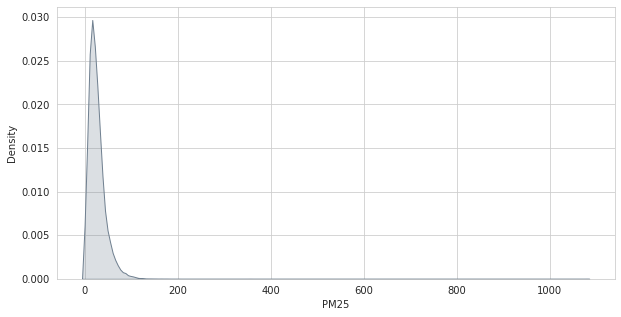

In [11]:
plt.figure(figsize=(10,5))
sns.kdeplot(x='PM25', data=sample[['PM25']], fill=True, color='slategray');

outliner :  99.0
339 / 69280


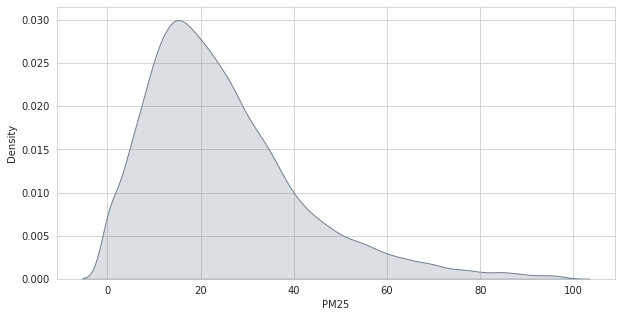

In [12]:
outliner = sample['PM25'].quantile(0.995)
print("outliner : ",  outliner)
print(sample[sample['PM25'] > outliner].shape[0], "/", sample.shape[0])
plt.figure(figsize=(10,5))
sns.kdeplot(x='PM25', data=sample[sample['PM25'] < outliner][['PM25']], fill=True, color='slategray');

In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

def split_data(raw_data, lookback,batch_size=2, outliner=None, target="PM25"):
  data = []

  if outliner is not None:
    # 이상치 미만 데이터만 사용
    raw_data2 = raw_data[raw_data[target] < outliner]
    data_raw = raw_data2.to_numpy() 
  else:
    data_raw = raw_data.to_numpy()

  y = np.reshape(data_raw[:, -1], (-1, 1))

  # create all possible sequences of length seq_len
  for index in range(len(data_raw) - lookback): 
      data.append(data_raw[index: index + lookback])
  
  data = np.array(data);
  test_set_size = int(np.round(0.1 * data.shape[0]));
  train_set_size = data.shape[0] - (test_set_size);
  
  x_train = torch.from_numpy(data[:train_set_size, :, :]).type(torch.Tensor)
  y_train = torch.from_numpy(y[lookback:train_set_size+lookback, :]).type(torch.Tensor)
  
  x_test = torch.from_numpy(data[train_set_size: , :, :]).type(torch.Tensor)
  y_test = torch.from_numpy(y[train_set_size+lookback:, :]).type(torch.Tensor)
  
  train_set = TensorDataset(x_train, y_train)
  test_set = TensorDataset(x_train, y_train)

  dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  dataloader2 = DataLoader(test_set, batch_size=batch_size, shuffle=True)

  return x_train, y_train, x_test, y_test, dataloader, dataloader2

In [26]:
x_train, y_train, x_test, y_test, dataloader, dataloader2 = split_data(sample, 20, 256, outliner=outliner)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([62008, 20, 10]) torch.Size([6890, 20, 10])
torch.Size([62008, 1]) torch.Size([6890, 1])


## GRU
Sequance Model의 한 종류로 LSTM의 간소화된 버전으로 알려져 있다.  


In [15]:
class GRU(nn.Module):
  def __init__(self, n_layers, hidden_dim, input_dim, n_classes=1, dropout_p=0.2):
      super(GRU, self).__init__()
      self.n_layers = n_layers
      self.hidden_dim = hidden_dim
      
      if n_layers > 1 :
        self.dropout = nn.Dropout(dropout_p)

      self.gru = nn.GRU(input_dim, self.hidden_dim, num_layers=self.n_layers, batch_first=True, dropout=dropout_p)
      self.fc = nn.Linear(self.hidden_dim, n_classes)

  def forward(self, x):
      h0 = self._init_state(x.size(0))
      out, (hn) = self.gru(x, (h0.detach()))
      out = self.fc(out[:, -1, :]) 
      return out

  def _init_state(self, batch_size=1):
      weight = next(self.parameters()).data
      return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(DEVICE)

## 학습 / 테스트 결과
- 100회 반복 학습하면서 Loss의 감소를 확인.  
- Loss는 Mean Square Error를 사용해서 측정.  
- Optimiser는 Adam을 사용하였음



In [16]:
def evaluate(model, val_iter):
  model.eval()
  corrects, total_loss = 0, 0
  
  for batch in val_iter:
    x, y = batch
    y_p = model(x.to(DEVICE))
    loss = torch.nn.MSELoss(reduction='mean')(y_p, y.to(DEVICE))
    total_loss += loss.item()

  size = len(val_iter)
  avg_loss = total_loss / size
  return avg_loss

In [27]:
import time
import numpy

num_epochs = 100
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

model = GRU(input_dim=len(X_label + y_label), hidden_dim=128, n_classes=1, n_layers=1).to(DEVICE)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
torch.cuda.empty_cache()
best_val_loss = None
for t in range(num_epochs):
  model.train()
  for batch_idx, samples in enumerate(dataloader):
    x, y = samples

    y_train_pred = model(x.to(DEVICE))
    # print("pridiction: ", y_train_pred[:10, :], "\n Real: ", y_train[:10])
    optimizer.zero_grad()
    loss = criterion(y_train_pred, y.to(DEVICE))
    
    loss.backward()
    optimizer.step()

  avg_loss = evaluate(model, dataloader2)

  if not best_val_loss or avg_loss < best_val_loss:
      if not os.path.isdir("snapshot"):
          os.makedirs("snapshot")
      torch.save(model.state_dict(), './snapshot/best_model.pt')
 
  if t % 20 == 0:
    print("Epoch ", t, "MSE: ", avg_loss)
  hist[t] = avg_loss

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch  0 MSE:  183.57268467655888
Epoch  20 MSE:  47.121760034757386
Epoch  40 MSE:  43.35250935338652
Epoch  60 MSE:  39.06950264604985
Epoch  80 MSE:  34.66173909819175
Training time: 137.05550122261047


### Learning rate check / 학습 결과 확인
Loss가 감소하는 양상을 확인 하였다. 교과서에 나오는 정석적인 모양이라 만족!! 😊  
학습된 모델을 기반으로 예측 값과 실제 값을 비교도 해보았다. 

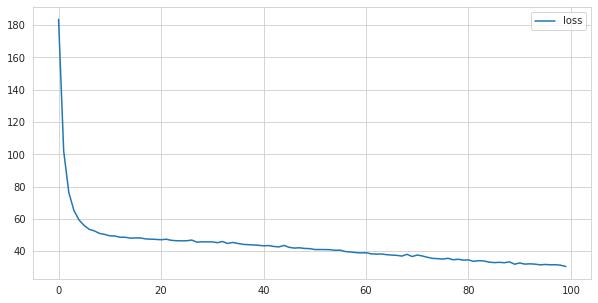

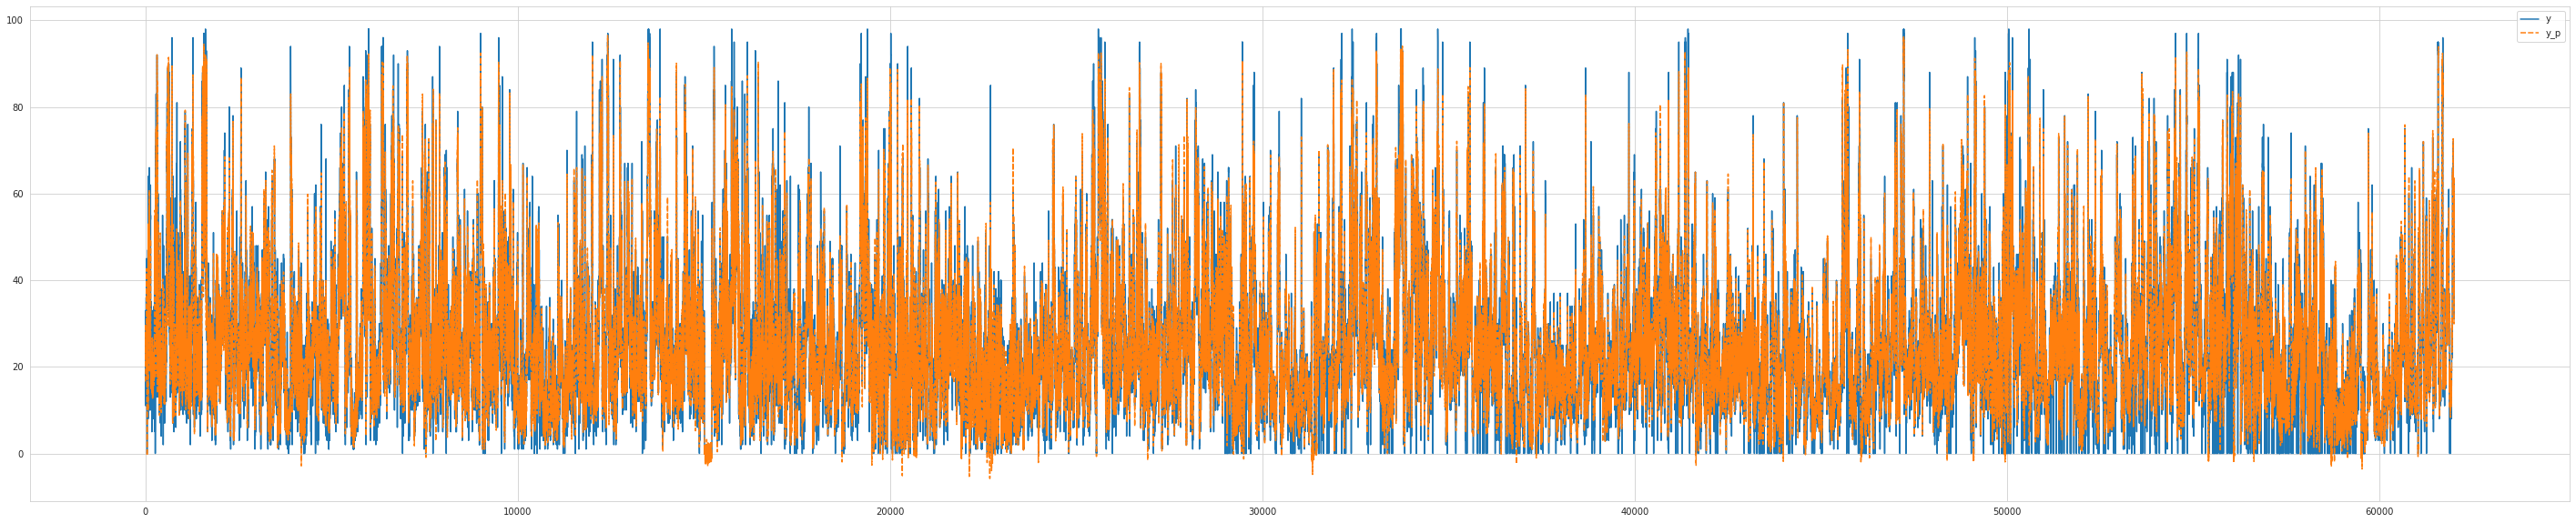

In [28]:
%matplotlib inline
import matplotlib.pylab as plt

plt.figure(figsize=(10,5))
sns.lineplot(data=pd.DataFrame(hist, columns=["loss"]))

model.eval()
prediction = model(x_train.to(DEVICE)) 
a = pd.DataFrame(y_train.view(-1), columns=["y"])
a["y_p"] = pd.Series(prediction.view(-1).cpu().detach().numpy())
plt.figure(figsize=(50,10))
sns.lineplot(data=a)

### 학습결과 
1. 미세먼지 데이터를 봤을 때 한 번씩 주변 시간 데이터에 비해 값이 크게 변화하는 경우가 있는데,  
해당 도메인의 지식이 없어서 해당 부분에 대한 전처리가 되지 않은 것이 영향을 준 거 같다.
2. 전체 데이터를 사용할 수 있게 최적화를 시도해서 학습을 한다.   
3. 새로운 Feature를 추가해 보는 것도 고민해보자.  
예) 강남구 주변의 미세먼지 데이터를 Feature로 사용. 

(6890,)
[31.332197]


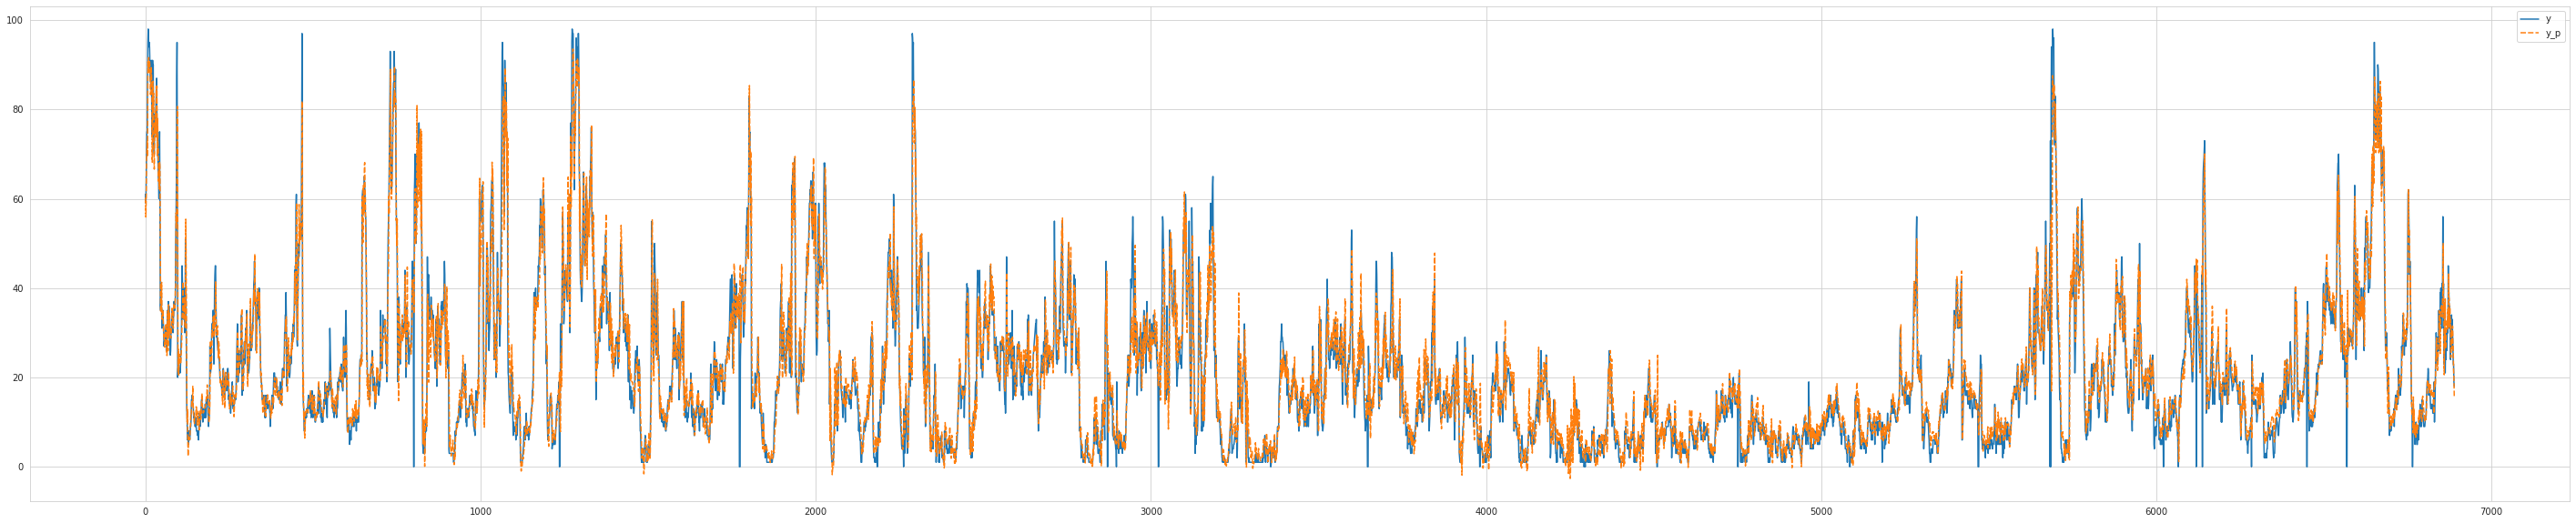

In [29]:
# model.load_state_dict(torch.load('./snapshot/best_model.pt'))
model.eval()
prediction = model(x_test.to(DEVICE)) 
print(prediction.view(-1).cpu().detach().numpy().shape)
a = pd.DataFrame(y_test.view(-1), columns=["y"])
a["y_p"] = pd.Series(prediction.view(-1).cpu().detach().numpy())

loss = sum((a[["y_p"]].values - a[["y"]].values)**2) / a.shape[0]
print(loss)
plt.figure(figsize=(50,10))
sns.lineplot(data=a)

In [ ]:
## SAVE MODEL / LEARNING RATE INFORMATION
# from google.colab import files
# files.download('./curve_2_model_3_batch.gif') 

### API 호출  
신규 기상 및 미세먼지 데이터 조회 후 모델에 적용하여 다음 1시간 뒤 미세먼지 데이터 예측  
1. 미세먼지 데이터 : 서울시 공공데이터에서 제공하는 시간별 평균 대기오염도 API를 호출하여 사용  
2. 기상 데이터 : 공공데이터포털의 종관기상관측 시간자료 (기상청, API) 

In [60]:
import requests
from time import sleep
import datetime as dt
import urllib3

def call_api(api_name, date, dir_name):
    api_key = open("/dataset/MyDrive/dust/api_key").readlines()[0].strip()
    url_format = 'http://openAPI.seoul.go.kr:8088/{api_key}/json/{api_name}/1/{end_index}/{date}'
    headers = {'content-type': 'application/json;charset=utf-8'}

    # 최초 1회 Call은 해당 일자의 데이터 수를 확인한다.
    url = url_format.format(api_name=api_name, api_key=api_key, end_index=1, date=date)
    response = requests.get(url, headers=headers)

    end_index = response.json()[api_name]["list_total_count"]
    print("Max Count(%s): %s" % (date, end_index))

    # 해당 일자의 모든 데이터를 불러온다.
    url = url_format.format(api_name=api_name, api_key=api_key, end_index=end_index, date=date)
    response = requests.get(url, headers=headers)
    result = pd.DataFrame(response.json()[api_name]["row"])
    result.to_csv("./dust_%s.csv" % (date), index=False, encoding="utf-8")

    return result


In [40]:
dust = call_api("TimeAverageAirQuality", "20210310", "dust")
dust.head()

<Response [200]>
Max Count(20210310): 600


,MSRDT,MSRSTE_NM,NO2,O3,CO,SO2,PM10,PM25
0,202103102300,성동구,0.095,0.007,0.9,0.003,157.0,120.0
1,202103102300,중구,0.085,0.010,0.8,0.003,156.0,98.0
2,202103102300,구로구,0.087,0.004,0.8,0.004,146.0,112.0
3,202103102300,노원구,0.074,0.003,1.1,0.005,116.0,82.0
4,202103102300,동대문구,0.069,0.018,0.9,0.004,137.0,96.0


In [58]:
def call_weather_api(date):
    # API 키는 공개하기 힘든 점 양해 바랍니다.
    api_key = open("/dataset/MyDrive/dust/api_key2").readlines()[0].strip()
    url_format = 'http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList?numOfRows=30&dataType=json&dataCd=ASOS&dateCd=HR&startDt={date}&startHh=00&endDt={date}&endHh=23&stnIds={snt_id}&schListCnt=100&pageIndex=1&serviceKey={api_key}'

    headers = {'content-type': 'application/json;charset=utf-8'}
    urllib3.disable_warnings()
    print("%s Weather" % date)
    url = url_format.format(api_key=api_key, date=date, snt_id="108")
    response = requests.get(url, headers=headers, verify=False)

    if response.status_code == 200:
        result = pd.DataFrame(response.json()["response"]["body"]["items"]["item"])
        result.to_csv("./weather_%s.csv" % date, index=False, encoding="utf-8")
        return result
    else:
      return None

In [39]:
weather = call_weather_api("20210310")
weather.columns = [c.upper() for c in weather.columns]
weather.shape

20210310 Weather
200
{'response': {'header': {'resultCode': '00', 'resultMsg': 'NORMAL_SERVICE'}, 'body': {'dataType': 'JSON', 'items': {'item': [{'tm': '2021-03-10 00:00', 'rnum': '1', 'stnId': '108', 'stnNm': '서울', 'ta': '4.9', 'taQcflg': '', 'rn': '', 'rnQcflg': '', 'ws': '1.6', 'wsQcflg': '', 'wd': '270', 'wdQcflg': '', 'hm': '83', 'hmQcflg': '', 'pv': '7.2', 'td': '2.2', 'pa': '1016.7', 'paQcflg': '', 'ps': '1027.4', 'psQcflg': '', 'ss': '', 'ssQcflg': '9', 'icsr': '', 'dsnw': '', 'hr3Fhsc': '', 'dc10Tca': '0', 'dc10LmcsCa': '0', 'clfmAbbrCd': '', 'lcsCh': '', 'vs': '791', 'gndSttCd': '', 'dmstMtphNo': '19', 'ts': '2.6', 'tsQcflg': '', 'm005Te': '7.0', 'm01Te': '6.8', 'm02Te': '7.2', 'm03Te': '7.2'}, {'tm': '2021-03-10 01:00', 'rnum': '2', 'stnId': '108', 'stnNm': '서울', 'ta': '4.3', 'taQcflg': '', 'rn': '', 'rnQcflg': '', 'ws': '1.7', 'wsQcflg': '', 'wd': '340', 'wdQcflg': '', 'hm': '84', 'hmQcflg': '', 'pv': '7.0', 'td': '1.8', 'pa': '1016.7', 'paQcflg': '', 'ps': '1027.4', 'psQc

(24, 38)

In [55]:
def concat_data(dust, weather):
    # Datetime 형태로 Index를 변경해줍니다.
    dust["MSRDT"] = dust["MSRDT"].apply(lambda x: dt.datetime.strptime(str(x), "%Y%m%d%H%M"))
    dust2 = dust.set_index("MSRDT")

    # Datetime 형태로 Index를 변경해줍니다.
    weather.columns = [c.upper() for c in weather.columns]
    weather["TM"] = weather["TM"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M"))
    weather2 = weather.set_index("TM")

    # join() 함수는 같은 iㅠndex 끼리의 join을 제공합니다.
    master = weather2.join(dust2, how="inner")
    return master

In [61]:
# 20210301 - 20210310 데이터 조회
dust_list = []
weather_list = []
for date in pd.date_range("20210301", "20210310").strftime("%Y%m%d"):
  dust_list.append(call_api("TimeAverageAirQuality", date, "dust"))
  weather_list.append(call_weather_api(date))

dust = pd.DataFrame(pd.concat(dust_list, sort=False))
weather = pd.DataFrame(pd.concat(weather_list, sort=False))

print(dust.head())
print(weather.head())

api_master = concat_data(dust, weather)
api_master.head()

Max Count(20210301): 600
20210301 Weather
Max Count(20210302): 600
20210302 Weather
Max Count(20210303): 600
20210303 Weather
Max Count(20210304): 600
20210304 Weather
Max Count(20210305): 600
20210305 Weather
Max Count(20210306): 600
20210306 Weather
Max Count(20210307): 600
20210307 Weather
Max Count(20210308): 600
20210308 Weather
Max Count(20210309): 600
20210309 Weather
Max Count(20210310): 600
20210310 Weather
          MSRDT MSRSTE_NM    NO2     O3   CO    SO2  PM10  PM25
0  202103012300       성동구  0.015  0.040  0.3  0.002   0.0   0.0
1  202103012300        중구  0.019  0.026  0.4  0.002   8.0   8.0
2  202103012300       구로구  0.019  0.029  0.3  0.002   6.0   1.0
3  202103012300       노원구  0.013  0.032  0.4  0.002   5.0   3.0
4  202103012300      동대문구  0.018  0.029  0.4  0.002   5.0   3.0
                 tm rnum stnId stnNm   ta  ... tsQcflg m005Te m01Te m02Te m03Te
0  2021-03-01 00:00    1   108    서울  9.0  ...            6.7   6.0   5.7   5.5
1  2021-03-01 01:00    2   108    서울

,RNUM,STNID,STNNM,TA,TAQCFLG,RN,RNQCFLG,WS,WSQCFLG,WD,WDQCFLG,HM,HMQCFLG,PV,TD,PA,PAQCFLG,PS,PSQCFLG,SS,SSQCFLG,ICSR,DSNW,HR3FHSC,DC10TCA,DC10LMCSCA,CLFMABBRCD,LCSCH,VS,GNDSTTCD,DMSTMTPHNO,TS,TSQCFLG,M005TE,M01TE,M02TE,M03TE,MSRSTE_NM,NO2,O3,CO,SO2,PM10,PM25
2021-03-01,1,108,서울,9.0,,,,2.7,,50,,46,,5.3,-2.0,1011.6,,1022.1,,,9,,,,10,5,,,2000,,,5.5,,6.7,6.0,5.7,5.5,서대문구,0.049,0.002,1.0,0.008,27.0,21.0
2021-03-01,1,108,서울,9.0,,,,2.7,,50,,46,,5.3,-2.0,1011.6,,1022.1,,,9,,,,10,5,,,2000,,,5.5,,6.7,6.0,5.7,5.5,강북구,0.041,0.003,0.6,0.003,27.0,16.0
2021-03-01,1,108,서울,9.0,,,,2.7,,50,,46,,5.3,-2.0,1011.6,,1022.1,,,9,,,,10,5,,,2000,,,5.5,,6.7,6.0,5.7,5.5,성동구,0.051,0.002,0.7,0.003,30.0,18.0
2021-03-01,1,108,서울,9.0,,,,2.7,,50,,46,,5.3,-2.0,1011.6,,1022.1,,,9,,,,10,5,,,2000,,,5.5,,6.7,6.0,5.7,5.5,강서구,0.054,0.002,0.9,0.006,54.0,34.0
2021-03-01,1,108,서울,9.0,,,,2.7,,50,,46,,5.3,-2.0,1011.6,,1022.1,,,9,,,,10,5,,,2000,,,5.5,,6.7,6.0,5.7,5.5,종로구,0.056,0.002,0.8,0.003,33.0,18.0


In [62]:
sample = api_master[api_master["MSRSTE_NM"]== "강남구"][X_label + y_label] # 서울시 강남구의 데이터만 사용
sample[X_label] = scaler.transform(sample[X_label])
print(sample)

                           HM        PA        PS  ...        WD        WS   PM25
2021-03-01 00:00:00 -0.161290  0.372180  0.365942  ... -0.722222 -0.526316   21.0
2021-03-01 01:00:00 -0.182796  0.368421  0.362319  ... -0.500000 -0.754386   25.0
2021-03-01 02:00:00 -0.139785  0.357143  0.351449  ... -0.611111 -0.754386   24.0
2021-03-01 03:00:00 -0.053763  0.323308  0.318841  ... -0.611111 -0.666667   32.0
2021-03-01 04:00:00  0.462366  0.342105  0.336957  ...  1.000000 -0.614035   29.0
...                       ...       ...       ...  ...       ...       ...    ...
2021-03-10 19:00:00 -0.053763  0.563910  0.547101  ...  0.388889 -0.543860   96.0
2021-03-10 20:00:00  0.096774  0.586466  0.572464  ...  0.500000 -0.684211  110.0
2021-03-10 21:00:00  0.118280  0.609023  0.594203  ...  0.500000 -0.631579  116.0
2021-03-10 22:00:00  0.096774  0.605263  0.590580  ...  0.388889 -0.614035  116.0
2021-03-10 23:00:00  0.161290  0.616541  0.605072  ...  0.388889 -0.807018  124.0

[240 rows x 10 

In [63]:
def generate_val_data(raw_data, lookback, target="PM25"):
  data = []

  data_raw = raw_data.to_numpy()

  y = np.reshape(data_raw[:, -1], (-1, 1))

  # create all possible sequences of length seq_len
  for index in range(len(data_raw) - lookback): 
      data.append(data_raw[index: index + lookback])
  
  data = np.array(data);
  x = torch.from_numpy(data).type(torch.Tensor)
  y = torch.from_numpy(y[lookback:, :]).type(torch.Tensor)

  dataloader = DataLoader(data)

  return x, y, dataloader

x, y, dataloader = generate_val_data(sample, 20)

print(x.shape, y.shape)

torch.Size([220, 20, 10]) torch.Size([220, 1])


(220,)
[48.7644]


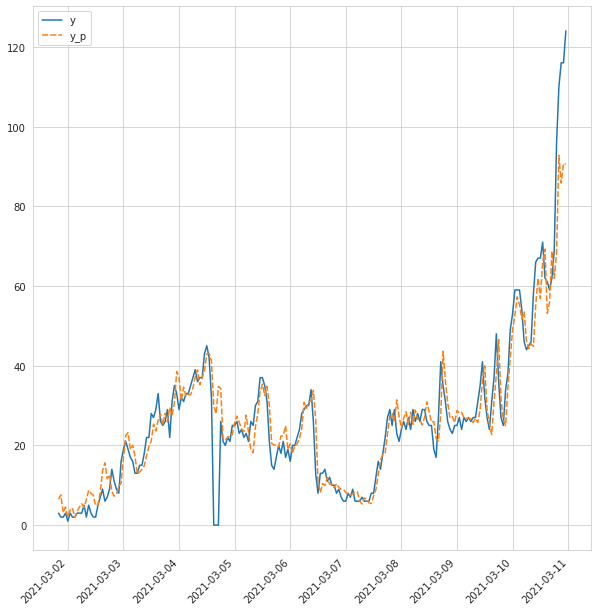

In [67]:
model.eval()
prediction = model(x.to(DEVICE)) 
print(prediction.view(-1).cpu().detach().numpy().shape)
a = pd.DataFrame(y.view(-1), columns=["y"])
a["y_p"] = pd.Series(prediction.view(-1).cpu().detach().numpy())
a.index = sample.index[20:]

loss = sum((a[["y_p"]].values - a[["y"]].values)**2) / a.shape[0]
print(loss)
plt.figure(figsize=(10,10))
plt.xticks(rotation=45, ha='right')
sns.lineplot(data=a)